## Project Overview

In this exciting Computer Vision project, our goal is to predict the damage status of a car.

Using Tensorflow, we will construct a Convolutional Neural Network (CNN) model to analyze images of cars and classify them as either damaged or undamaged.

Additionally, to improve the accuracy and efficiency of our model, we will explore the implementation of Transfer Learning, where a pre-trained model will be fine-tuned for our specific use case. With these techniques, we aim to create a reliable and effective solution for detecting car damage.

## Import libraries

In [20]:
# Visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
import pandas as pd

# Others
import random
import numpy as np
import os

# Image Generation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as ig

# Libraries for Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop, Adamax
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Conv2D,
    MaxPool2D,
    Flatten,
    GlobalAveragePooling2D
)

# Transfer Learning
from tensorflow.keras.applications import VGG16, DenseNet121

# Metrics
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score, 
    confusion_matrix,
    recall_score, 
    f1_score,
    precision_score,
    recall_score
)

# Keras tuner
from kerastuner.tuners import RandomSearch

from keras.callbacks import EarlyStopping


# Supress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
class_names = ['Damaged', 'Whole']

INPUT_SHAPE = (128, 128)

## Data analysis

In [3]:
# Function to plot the distribution
def plot_counts(counts, name):
    plt.figure(figsize = (5,5))
    f = sns.barplot(x = class_names, y = counts)
    plt.xlabel("Class labels", fontsize = 12)
    plt.ylabel('Count', fontsize = 12)
    plt.title("Images in " + name + ' folder', fontsize = 15)
    plt.show()

In [4]:
# Define train and test directories

train_dir = 'data/data1a/training/'
test_dir = 'data/data1a/validation/'

train_dir_damaged = train_dir + '00-damage/'
train_dir_whole = train_dir + '01-whole/'

test_dir_damaged = test_dir + '00-damage/'
test_dir_whole = test_dir + '01-whole/'

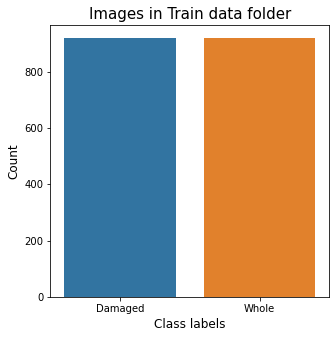

Number of damaged train observations: 920
Number of whole train observations: 920


In [5]:
# Show distribution of train images

train_damaged_num = len(os.listdir(train_dir_damaged))
train_whole_num = len(os.listdir(train_dir_whole))

plot_counts([train_damaged_num, train_whole_num], 'Train data')

print("Number of damaged train observations: {}".format(train_damaged_num))
print("Number of whole train observations: {}".format(train_whole_num))

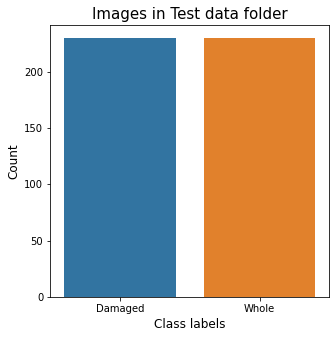

Number of damaged test observations: 230
Number of whole test observations: 230


In [6]:
# Show distribution of test images

test_damaged_num = len(os.listdir(test_dir_damaged))
test_whole_num = len(os.listdir(test_dir_whole))

plot_counts([test_damaged_num, test_whole_num], 'Test data')

print("Number of damaged test observations: {}".format(test_damaged_num))
print("Number of whole test observations: {}".format(test_whole_num))

As you can see on the plot above, we have pretty balanced dataset. It is very good ratio to train the model.

### Check Image Shapes

In [7]:
# Function to get shapes of the images in a folder
def get_image_shapes(files,path):
    shapes = []
    for i in files:
        img = cv2.imread(path + '/' + i)
        shapes.append(img.shape)
    return shapes

# Function to plot 10 most frequent image shapes 
def plot_image_shapes(title, feat, df):
    num = [str(i) for i in df[feat].value_counts().index[:10]]
    counts_val = [i for i in df[feat].value_counts()[:10]]
    plt.figure(figsize = (30, 5))
    plt.subplot(1,2,1)
    sns.barplot(x = num,y = counts_val)
    plt.xlabel("Image shapes", fontsize = 12)
    plt.ylabel('Counts', fontsize = 12)
    plt.title("Most frequent image shapes in {} folder".format(title), fontsize = 15)

In [8]:
# Create lists with images shapes
train_dmg = get_image_shapes(os.listdir(train_dir_damaged), train_dir_damaged)
train_whole = get_image_shapes(os.listdir(train_dir_whole), train_dir_whole)

test_dmg = get_image_shapes(os.listdir(test_dir_damaged), test_dir_damaged)
test_whole = get_image_shapes(os.listdir(test_dir_whole), test_dir_whole)

# Create train and test dataframes with image shapes to plot it
train_df = pd.DataFrame(list(zip(train_dmg, train_whole)), columns = class_names)
test_df = pd.DataFrame(list(zip(test_dmg, test_whole)), columns = class_names)

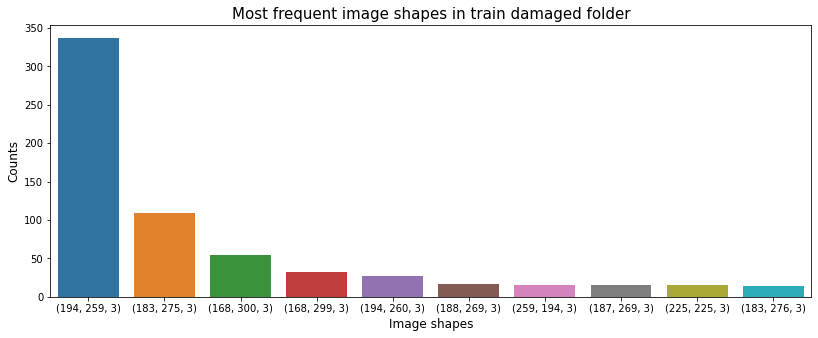

In [9]:
plot_image_shapes("train damaged", class_names[0], train_df)

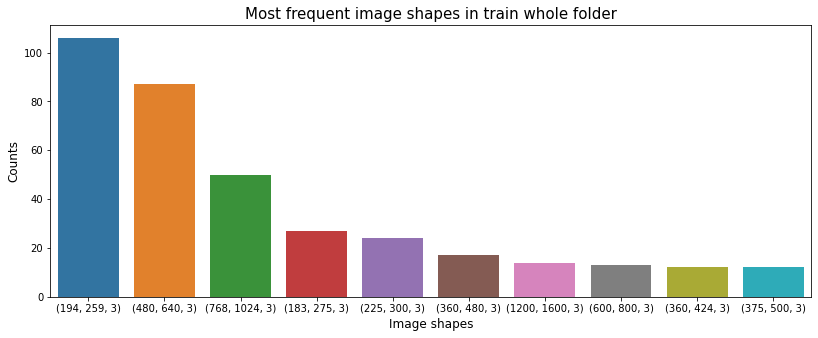

In [10]:
plot_image_shapes("train whole", class_names[1], train_df)

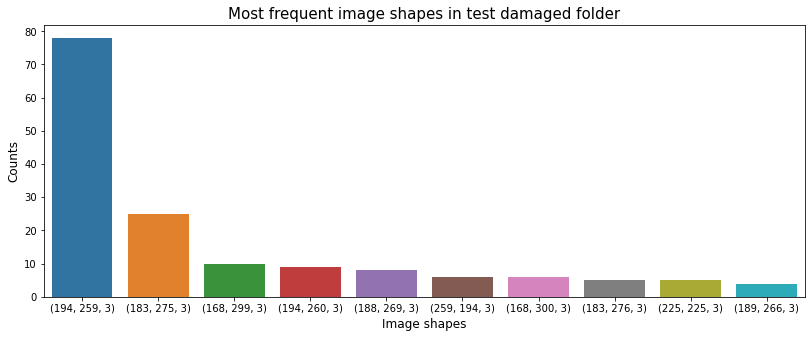

In [11]:
plot_image_shapes("test damaged", class_names[0], test_df)

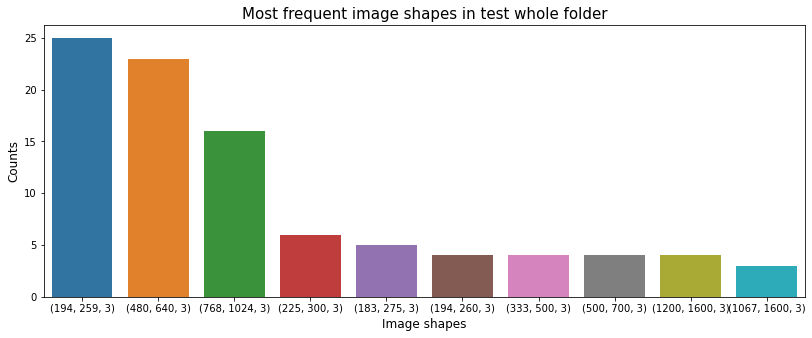

In [12]:
plot_image_shapes("test whole", class_names[1], test_df)

After observing the shape of images, we determined that images have different shapes.

Thats why we have to resize the shapes during data preprocessing.

In [21]:
# Function to show 9 random image samples from given folder.
def show_images(image_dir, size):
    images = os.listdir(image_dir)
    random_images = random.sample(images, 9)
    
    plt.figure(figsize = (10, 10))
    for i, image_name in enumerate(random_images):
        im = cv2.imread(os.path.join(image_dir, image_name))
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, size)
        
        plt.subplot(3, 3, i + 1)
        plt.title(image_name)
        plt.axis("off")
        plt.imshow(im)
    plt.show()

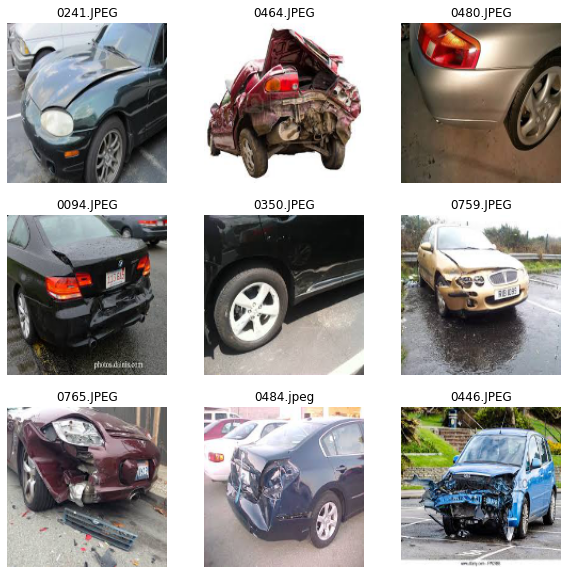

In [27]:
# Observing damaged samples from train folder
show_images(train_dir_damaged, (150, 150))

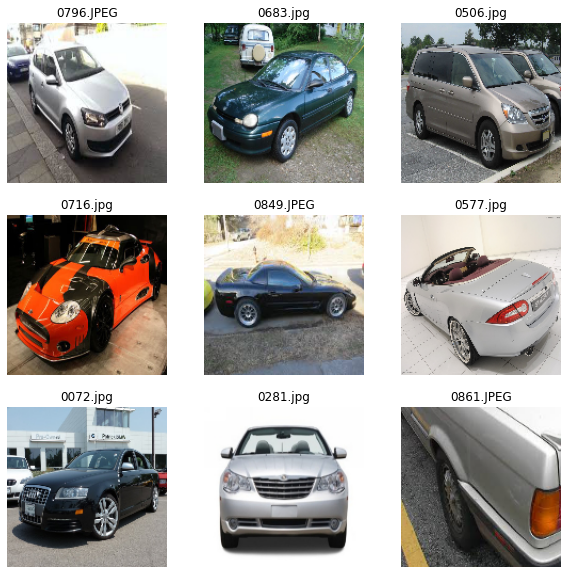

In [25]:
# Observing whole samples from train folder
show_images(train_dir_whole, (150, 150))

## Data Preprocessing

In [16]:
# Initialize Image Generators for Data Augmentation

train_data_gen = ImageDataGenerator(
    rescale = 1/255, # Data scaling
    rotation_range = 45, # Randomly rotating the images
    shear_range = 0.2, # Randomly applying shearing transformations to the images
    zoom_range = 0.2, # Randomly zooming in and out of the images
    width_shift_range = 0.1, # Randomly shifting the images horizontally
    horizontal_flip = True # Randomly flipping the images horizontally
)

test_data_gen = ImageDataGenerator(rescale = 1/255)

In [17]:
train_set = train_data_gen.flow_from_directory(
    train_dir,
    target_size = INPUT_SHAPE,
    class_mode = 'binary',
    shuffle = True
)

test_set = test_data_gen.flow_from_directory(
    test_dir,
    target_size = INPUT_SHAPE,
    class_mode = 'binary')

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


## Model Training

In [18]:
# Function to plot train and test metrics during the training process.
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))

    ax[0].set_title('Loss')
    ax[0].plot(history.epoch, history.history['loss'], label = 'Train loss')
    ax[0].plot(history.epoch, history.history['val_loss'], label = 'Validation loss')

    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, history.history['accuracy'], label = 'Train acc')
    ax[1].plot(history.epoch, history.history['val_accuracy'], label = 'Validation acc')

    ax[0].legend()
    ax[1].legend()

In [19]:
# Function to get true labels and predictions of the given model.
def get_predictions(folder, model):
    labels = ["00-damage", "01-whole"]
    y_true = []
    predictions = []

    for i in range(len(os.listdir(folder))):
        for item in os.listdir(os.path.join(folder, labels[i])):
            img = cv2.imread(os.path.join(folder, labels[i], item))
            img = cv2.resize(img, INPUT_SHAPE)
            img = img / 255
            img = img.reshape(-1, INPUT_SHAPE[0], INPUT_SHAPE[1], 3)
            pred = model.predict(x = img, verbose = 0)
            pred = 1 if pred > 0.5 else 0
            predictions.append(pred)
            y_true.append(i)
    
    return y_true, predictions

# Function to evaluate model with different metrics.
def score_func(model, train_set, test_set):
    scores_train = model.evaluate(x = train_set, verbose = 0)
    
    scores_test = model.evaluate(x = test_set, verbose = 0)
    
    y_test, pred = get_predictions(test_dir, model)
    
    accuracy_train = round(scores_train[1], 3)
    
    accuracy_test = round(scores_test[1], 3)
    
    precision = round(precision_score(y_test, pred), 3)
    
    recall = round(recall_score(y_test, pred), 3)
    
    f1 = round(f1_score(y_test, pred), 3)
    
    cm = confusion_matrix(y_test, pred)
    
    return accuracy_train, accuracy_test, precision, recall, f1, cm

In [20]:
# Check GPU connection for TensorFlow
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [21]:
# Create lists to store training results
model_name_list = []

accuracy_train_score_list = []

accuracy_test_score_list = []

precision_score_list = []

recall_score_list = []

f1_score_list = []

cm_list = []

history_epochs_dict = {}

### Find hyperparameters using Keras Tuner

In [38]:
# Function with model builder for hyperparameters tuning
def build_model(hp):
    conv_layers_num = hp.Int("conv_layers_num", min_value = 1, max_value = 3, step = 1)
    
    conv_filters = hp.Int("conv_filters", min_value = 32, max_value = 64, step = 16)
    
    dropout_rate = hp.Float("dropout_rate", min_value = 0.2, max_value = 0.3, step = 0.1)
    
    hp_learning_rate = hp.Choice("learning_rate", values = [1e-3, 1e-4])
    
    hp_dense_num = hp.Int("dense_num", min_value = 128, max_value = 256, step = 64)
    
    optimizers_dict = {
        "Adam": Adam(learning_rate = hp_learning_rate),
        "SGD": SGD(learning_rate = hp_learning_rate),
        "RMSprop": RMSprop(learning_rate = hp_learning_rate)
    }
    
    hp_opt = hp.Choice(
        'optimizer',
        values = ["Adam", "SGD", "RMSprop"])
    
    pool_size = (2, 2)
    
    model = Sequential()
    
    model.add(Conv2D(conv_filters, 3, activation = "relu", input_shape = (INPUT_SHAPE[0], INPUT_SHAPE[1], 3)))
    
    model.add(MaxPool2D(pool_size = pool_size))
    
    model.add(Dropout(dropout_rate))
    
    for i in range(conv_layers_num):
        model.add(Conv2D(conv_filters, 3, activation = "relu"))
    
        model.add(MaxPool2D(pool_size = pool_size))
    
        model.add(Dropout(dropout_rate))  
        
    model.add(Flatten())
    
    model.add(Dense(
        hp_dense_num,
        activation = "relu",
        kernel_regularizer = "l2",
        bias_regularizer = "l2"))
    
    model.add(Dropout(rate = 0.5))
    
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(
        optimizer = optimizers_dict[hp_opt],
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )
    
    return model

In [39]:
# Implement EarlyStopping for callbacks
callbacks = [
    EarlyStopping(
        monitor = 'val_loss',
        patience = 10)
]

In [40]:
tuner = RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 30,
    executions_per_trial = 3,
    directory = 'keras_tuner',
    project_name = 'car_damage_detection')

tuner.search(
    train_set,
    epochs = 50,
    verbose = 1,
    steps_per_epoch = len(train_set),
    validation_data = test_set,
    validation_steps = len(test_set),
    batch_size = 64,
    callbacks = callbacks)

Trial 30 Complete [00h 17m 45s]
val_accuracy: 0.7289854884147644

Best val_accuracy So Far: 0.8202898701032003
Total elapsed time: 15h 54m 30s
INFO:tensorflow:Oracle triggered exit


In [41]:
# Observe best hyperparameters for this model
best_hps = tuner.get_best_hyperparameters(1)[0]

print(best_hps.values)

{'conv_layers_num': 3, 'conv_filters': 48, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.001, 'dense_num': 128, 'optimizer': 'Adam'}


In [42]:
batch_size_list = [32, 64, 128, 256]

for batch_size in batch_size_list:
    best_model = tuner.hypermodel.build(best_hps)
    
    history = best_model.fit(
        train_set,
        epochs = 100,
        verbose = 1,
        steps_per_epoch = len(train_set),
        validation_steps = len(test_set),
        validation_data = test_set,
        batch_size = batch_size,
        callbacks = callbacks)

    best_model.save("model_keras_tuner_batch_{}.h5".format(batch_size))
    
    history_epochs_dict["model_keras_tuner_batch_{}".format(batch_size)] = history
    
    accuracy_train, accuracy_test, precision, recall, f1, cm = score_func(best_model, train_set, test_set)

    model_name_list.append("model_keras_tuner_batch_{}".format(batch_size))

    accuracy_train_score_list.append(accuracy_train)
 
    accuracy_test_score_list.append(accuracy_test)

    precision_score_list.append(precision)

    recall_score_list.append(recall)

    f1_score_list.append(f1)

    cm_list.append(cm)

Epoch 1/100
58/58 [==============================] - 17s 284ms/step - loss: 1.6433 - accuracy: 0.5022 - val_loss: 0.8887 - val_accuracy: 0.5543
Epoch 2/100
58/58 [==============================] - 16s 278ms/step - loss: 0.7657 - accuracy: 0.5685 - val_loss: 0.7010 - val_accuracy: 0.5935
Epoch 3/100
58/58 [==============================] - 16s 281ms/step - loss: 0.6842 - accuracy: 0.6272 - val_loss: 0.6565 - val_accuracy: 0.6348
Epoch 4/100
58/58 [==============================] - 16s 275ms/step - loss: 0.6540 - accuracy: 0.6478 - val_loss: 0.6447 - val_accuracy: 0.6674
Epoch 5/100
58/58 [==============================] - 16s 277ms/step - loss: 0.6695 - accuracy: 0.6277 - val_loss: 0.6611 - val_accuracy: 0.6304
Epoch 6/100
58/58 [==============================] - 16s 277ms/step - loss: 0.6449 - accuracy: 0.6614 - val_loss: 0.6936 - val_accuracy: 0.6065
Epoch 7/100
58/58 [==============================] - 16s 279ms/step - loss: 0.6515 - accuracy: 0.6457 - val_loss: 0.6581 - val_accuracy:

58/58 [==============================] - 16s 282ms/step - loss: 0.6540 - accuracy: 0.6696 - val_loss: 0.6291 - val_accuracy: 0.7065
Epoch 12/100
58/58 [==============================] - 16s 281ms/step - loss: 0.6360 - accuracy: 0.6875 - val_loss: 0.6636 - val_accuracy: 0.6804
Epoch 13/100
58/58 [==============================] - 16s 285ms/step - loss: 0.6504 - accuracy: 0.6609 - val_loss: 0.6164 - val_accuracy: 0.6935
Epoch 14/100
58/58 [==============================] - 16s 283ms/step - loss: 0.6308 - accuracy: 0.6832 - val_loss: 0.6016 - val_accuracy: 0.7304
Epoch 15/100
58/58 [==============================] - 16s 278ms/step - loss: 0.6362 - accuracy: 0.6761 - val_loss: 0.6198 - val_accuracy: 0.7043
Epoch 16/100
58/58 [==============================] - 16s 281ms/step - loss: 0.6245 - accuracy: 0.6913 - val_loss: 0.6075 - val_accuracy: 0.7174
Epoch 17/100
58/58 [==============================] - 16s 278ms/step - loss: 0.6476 - accuracy: 0.6815 - val_loss: 0.5912 - val_accuracy: 0.737

58/58 [==============================] - 17s 284ms/step - loss: 0.5164 - accuracy: 0.7957 - val_loss: 0.4633 - val_accuracy: 0.8152
Epoch 57/100
58/58 [==============================] - 16s 281ms/step - loss: 0.5316 - accuracy: 0.7750 - val_loss: 0.4637 - val_accuracy: 0.8152
Epoch 58/100
58/58 [==============================] - 17s 290ms/step - loss: 0.5050 - accuracy: 0.7940 - val_loss: 0.4710 - val_accuracy: 0.8304
Epoch 59/100
58/58 [==============================] - 17s 288ms/step - loss: 0.5045 - accuracy: 0.7880 - val_loss: 0.4419 - val_accuracy: 0.8326
Epoch 60/100
58/58 [==============================] - 17s 292ms/step - loss: 0.5165 - accuracy: 0.7924 - val_loss: 0.5349 - val_accuracy: 0.7913
Epoch 61/100
58/58 [==============================] - 17s 287ms/step - loss: 0.5162 - accuracy: 0.7837 - val_loss: 0.4754 - val_accuracy: 0.8239
Epoch 62/100
58/58 [==============================] - 16s 275ms/step - loss: 0.4965 - accuracy: 0.7973 - val_loss: 0.4551 - val_accuracy: 0.839

### Evaluation results after hyperparameters tuning

In [22]:
# Function to show the top 10 models sorted by the specified metric
def results_plot(metric, df):
    plt.figure(figsize=(12, 5))
    
    df = df.loc[(df[metric] != 0)]
    
    sns.barplot(data = df.sort_values(by = metric, ascending = False).head(10), 
            x = metric, y = 'Model')
    plt.title(metric, fontsize = 12)
    plt.xlabel(metric)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.show()

In [43]:
model_results_df = pd.DataFrame({
    'Model': model_name_list,
    'accuracy_train': accuracy_train_score_list, 
    'accuracy_test': accuracy_test_score_list, 
    'precision_score': precision_score_list,
    'recall_score': recall_score_list,
    'f1_score': f1_score_list
})

In [44]:
model_results_df

,Model,accuracy_train,accuracy_test,precision_score,recall_score,f1_score
0,model_keras_tuner_batch_32,0.779,0.770,0.757,0.839,0.796
1,model_keras_tuner_batch_64,0.810,0.765,0.729,0.900,0.805
2,model_keras_tuner_batch_128,0.788,0.809,0.870,0.696,0.773
3,model_keras_tuner_batch_256,0.827,0.830,0.847,0.770,0.806


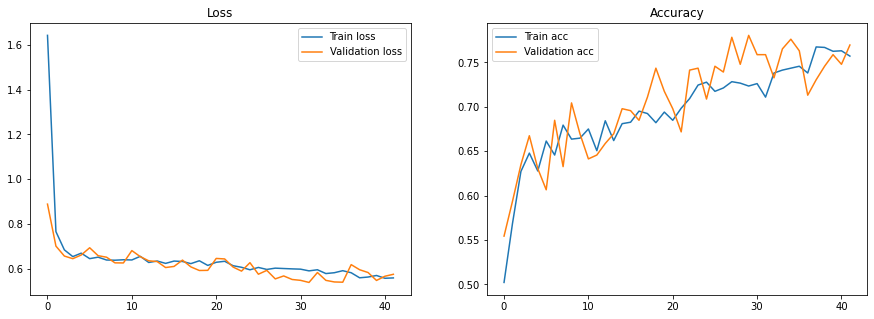

In [45]:
show_final_history(history_epochs_dict["model_keras_tuner_batch_32"])

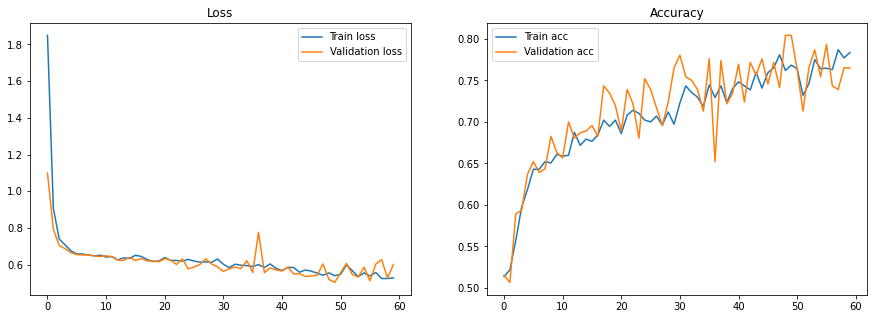

In [46]:
show_final_history(history_epochs_dict["model_keras_tuner_batch_64"])

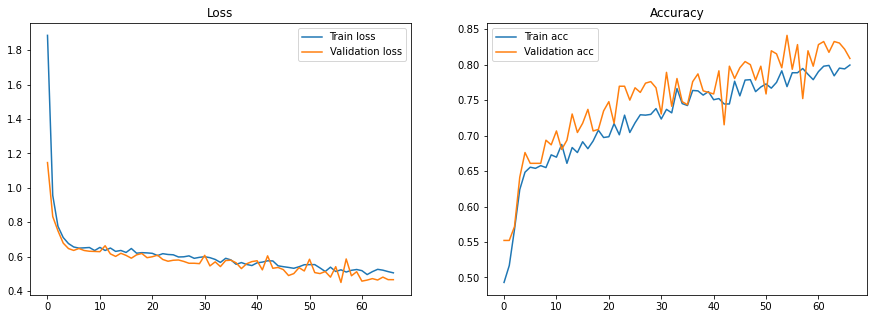

In [47]:
show_final_history(history_epochs_dict["model_keras_tuner_batch_128"])

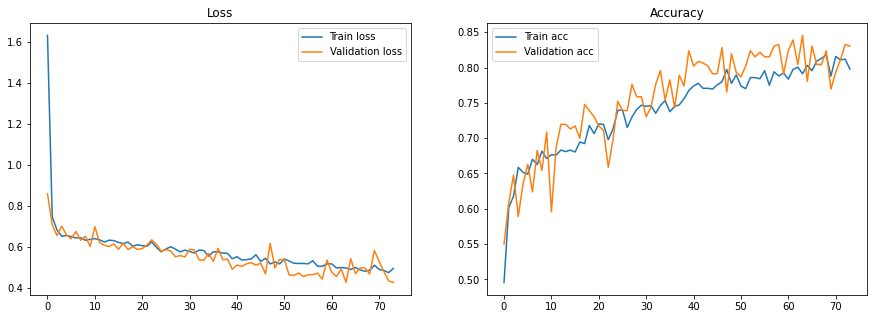

In [48]:
show_final_history(history_epochs_dict["model_keras_tuner_batch_256"])

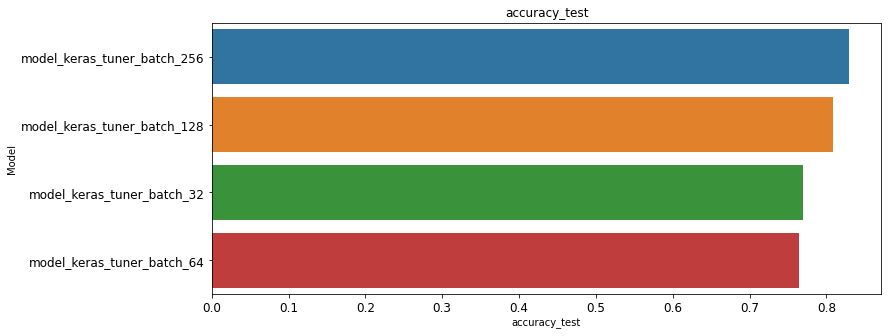

In [76]:
results_plot("accuracy_test", model_results_df)

As we can see, the best result was achieved with 256 batch size and Adam optimizer.

Also, we realized that we can reduce the number of epochs.

After hyperparameters tuning we've got pretty good results, but I think we can improve the scores.

Let's try to implement transfer learning to get better results.

## Transfer Learning Implementation

### VGG16

VGG16 is a Convolutional Neural Network (CNN) architecture for image classification tasks.

It was developed by the Visual Geometry Group (VGG) at the University of Oxford and was introduced in the 2014 paper "Very Deep Convolutional Networks for Large-Scale Image Recognition". The model is named after the number of weight layers (16) in the network. It is known for its simplicity and for being the first model to achieve high accuracy on the ImageNet dataset. VGG16 is still widely used today as a base model for transfer learning and fine-tuning on other image recognition tasks.

### VGG16 Architecture
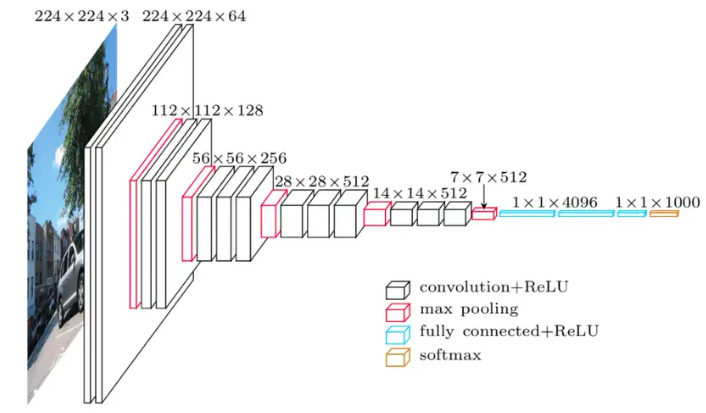

In [63]:
base_model = VGG16(
    input_shape = (INPUT_SHAPE[0], INPUT_SHAPE[1], 3),
    include_top = False, # Disable fully-connected layers
    weights = 'imagenet'
)

# Prevent weights of model being updated during training
base_model.trainable = False

In [64]:
head_model = base_model.output
head_model = MaxPool2D(pool_size = (2, 2))(head_model)
head_model = Dropout(0.4)(head_model)
head_model = Flatten()(head_model)
head_model = Dense(
    128,
    activation = "relu",
    kernel_regularizer = "l2",
    bias_regularizer = "l2")(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(1, activation = "sigmoid")(head_model)

In [65]:
model_vgg16 = Model(inputs = base_model.input, outputs = head_model)

In [66]:
model_vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [67]:
model_vgg16.compile(
    loss = "binary_crossentropy",
    optimizer = Adam(learning_rate = 1e-4),
    metrics = ["accuracy"] 
)

In [68]:
history_vgg16 = model_vgg16.fit(
    train_set,
    epochs = 50, 
    steps_per_epoch = len(train_set),
    validation_steps = len(test_set),
    validation_data = test_set,
    callbacks = callbacks,
    batch_size = 256
)

Epoch 1/50
58/58 [==============================] - 18s 298ms/step - loss: 2.9346 - accuracy: 0.6103 - val_loss: 2.6222 - val_accuracy: 0.7370
Epoch 2/50
58/58 [==============================] - 17s 299ms/step - loss: 2.5582 - accuracy: 0.7038 - val_loss: 2.2797 - val_accuracy: 0.8283
Epoch 3/50
58/58 [==============================] - 17s 300ms/step - loss: 2.2746 - accuracy: 0.7348 - val_loss: 2.1114 - val_accuracy: 0.7696
Epoch 4/50
58/58 [==============================] - 17s 300ms/step - loss: 2.0538 - accuracy: 0.7511 - val_loss: 1.9076 - val_accuracy: 0.7913
Epoch 5/50
58/58 [==============================] - 17s 290ms/step - loss: 1.8915 - accuracy: 0.7538 - val_loss: 1.7425 - val_accuracy: 0.8109
Epoch 6/50
58/58 [==============================] - 17s 295ms/step - loss: 1.7445 - accuracy: 0.7717 - val_loss: 1.6877 - val_accuracy: 0.7543
Epoch 7/50
58/58 [==============================] - 17s 292ms/step - loss: 1.6262 - accuracy: 0.7701 - val_loss: 1.5084 - val_accuracy: 0.8261

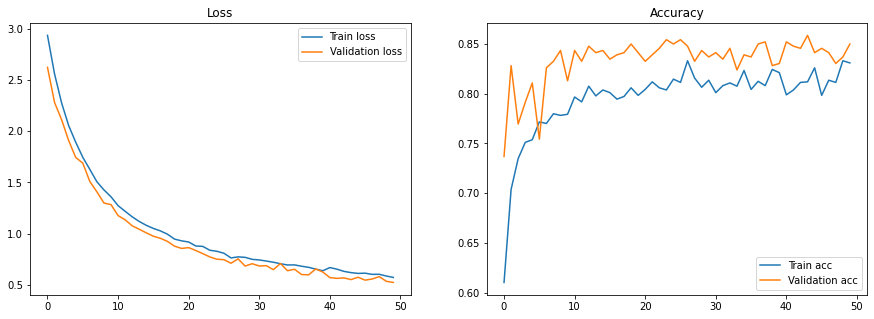

In [69]:
show_final_history(history_vgg16)

In [155]:
model_vgg16.save("model_vgg16.h5")

In [71]:
accuracy_train, accuracy_test, precision, recall, f1, cm = score_func(model_vgg16, train_set, test_set)

In [81]:
# Check for overfit problem
print("Train accuracy score: {}".format(accuracy_train))
print("Test accuracy score: {}".format(accuracy_test))

Train accuracy score: 0.839
Test accuracy score: 0.85


In [75]:
model_name_list.append("model_vgg16")

accuracy_train_score_list.append(accuracy_train)

accuracy_test_score_list.append(accuracy_test)

precision_score_list.append(precision)

recall_score_list.append(recall)

f1_score_list.append(f1)

cm_list.append(cm)

## DenseNet121

Dense121 is a deep learning model for image classification tasks. It is a type of Convolutional Neural Network (CNN) that uses dense connections between the layers in the network.

It was developed by the Facebook AI Research team and is named after the number of layers (121) in the model. The model is widely used in computer vision and image classification applications due to its high accuracy and fast inference speed.
### DenseNet Architecture 
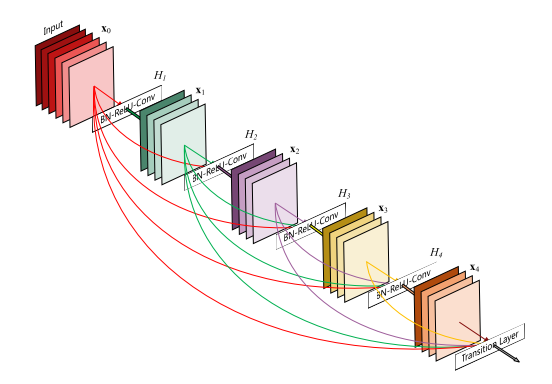

In [77]:
base_model = DenseNet121(
    input_shape = (INPUT_SHAPE[0], INPUT_SHAPE[1], 3),
    include_top = False, # Disable fully-connected layers
    weights = 'imagenet'
)

base_model.trainable = False

head_model = base_model.output
head_model = MaxPool2D(pool_size = (2, 2))(head_model)
head_model = Dropout(0.4)(head_model)
head_model = Flatten()(head_model)
head_model = Dense(
    128,
    activation = "relu",
    kernel_regularizer = "l2",
    bias_regularizer = "l2")(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(1, activation = "sigmoid")(head_model)

In [78]:
model_densenet121 = Model(inputs = base_model.input, outputs = head_model)

model_densenet121.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 134, 134, 3)  0          ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                            

 conv2_block4_1_conv (Conv2D)   (None, 32, 32, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 16, 16, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block2_1_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 16, 16, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv3_block11_0_bn (BatchNorma  (None, 16, 16, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 16, 16, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 16, 16, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 8, 8, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 8, 8, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 8, 8, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization) 

 conv4_block7_1_conv (Conv2D)   (None, 8, 8, 128)    57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 8, 8, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 8, 8, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 8, 8, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 8, 8, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 8, 8, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block20_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 8, 8, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
          

                                                                                                  
 conv4_block24_concat (Concaten  (None, 8, 8, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 8, 8, 1024)   4096        ['conv4_block24_concat[0][0]']   
                                                                                                  
 pool4_relu (Activation)        (None, 8, 8, 1024)   0           ['pool4_bn[0][0]']               
                                                                                                  
 pool4_conv (Conv2D)            (None, 8, 8, 512)    524288      ['pool4_relu[0][0]']             
                                                                                                  
 pool4_poo

 conv5_block4_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 4, 4, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 4, 4, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 4, 4, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 4, 4, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 4, 4, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_1_relu (Activatio  (None, 4, 4, 128)   0           ['conv5_block9_1_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 4, 4, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
                                                                                                  
 conv5_blo

                                                                                                  
Total params: 7,562,049
Trainable params: 524,545
Non-trainable params: 7,037,504
__________________________________________________________________________________________________


In [82]:
model_densenet121.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate = 1e-4),
    metrics = ['accuracy']
)

history = model_densenet121.fit(
    train_set,
    epochs = 50,
    steps_per_epoch = len(train_set),
    validation_steps = len(test_set),
    validation_data = test_set,
    callbacks = callbacks,
    batch_size = 256
)

Epoch 1/50
58/58 [==============================] - 23s 326ms/step - loss: 2.4472 - accuracy: 0.7592 - val_loss: 2.0840 - val_accuracy: 0.7935
Epoch 2/50
58/58 [==============================] - 17s 290ms/step - loss: 2.0837 - accuracy: 0.7734 - val_loss: 1.8547 - val_accuracy: 0.8022
Epoch 3/50
58/58 [==============================] - 17s 293ms/step - loss: 1.8520 - accuracy: 0.7853 - val_loss: 1.7282 - val_accuracy: 0.7870
Epoch 4/50
58/58 [==============================] - 17s 292ms/step - loss: 1.6893 - accuracy: 0.7967 - val_loss: 1.5960 - val_accuracy: 0.8087
Epoch 5/50
58/58 [==============================] - 17s 297ms/step - loss: 1.5734 - accuracy: 0.8212 - val_loss: 1.4995 - val_accuracy: 0.8152
Epoch 6/50
58/58 [==============================] - 17s 290ms/step - loss: 1.5482 - accuracy: 0.7978 - val_loss: 1.4544 - val_accuracy: 0.8065
Epoch 7/50
58/58 [==============================] - 18s 305ms/step - loss: 1.4323 - accuracy: 0.8250 - val_loss: 1.3843 - val_accuracy: 0.8152

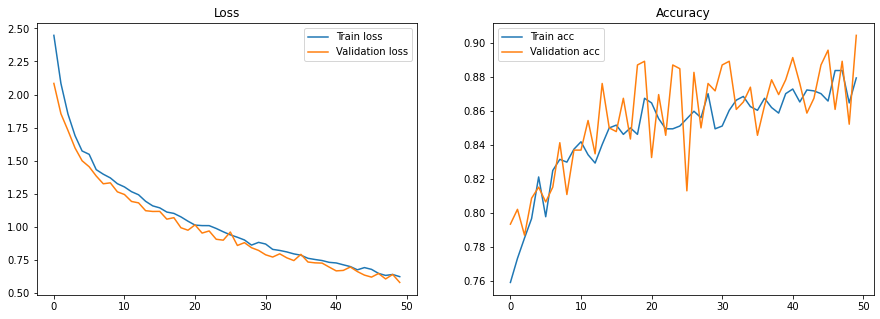

In [83]:
show_final_history(history)

In [154]:
model_densenet121.save("model_densenet121.h5")

In [84]:
accuracy_train, accuracy_test, precision, recall, f1, cm = score_func(model_densenet121, train_set, test_set)

In [85]:
# Check for overfit problem
print("Train accuracy score: {}".format(accuracy_train))
print("Test accuracy score: {}".format(accuracy_test))

Train accuracy score: 0.893
Test accuracy score: 0.904


In [86]:
model_name_list.append("model_densenet121")

accuracy_train_score_list.append(accuracy_train)

accuracy_test_score_list.append(accuracy_test)

precision_score_list.append(precision)

recall_score_list.append(recall)

f1_score_list.append(f1)

cm_list.append(cm)

## Results

In [92]:
# Function to show a heatmap of the confusion matrix
def plot_cm(model, cm):
    f, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cm, annot = True, linewidths=0.5, linecolor="red", fmt = ".0f", ax = ax)
    plt.title(model)
    plt.xlabel("y_pred")
    plt.ylabel("y_test")
    plt.show()

In [88]:
model_results_df = pd.DataFrame({
    'Model': model_name_list,
    'accuracy_train': accuracy_train_score_list, 
    'accuracy_test': accuracy_test_score_list, 
    'precision_score': precision_score_list,
    'recall_score': recall_score_list,
    'f1_score': f1_score_list
})

In [90]:
model_results_df

,Model,accuracy_train,accuracy_test,precision_score,recall_score,f1_score
0,model_keras_tuner_batch_32,0.779,0.770,0.757,0.839,0.796
1,model_keras_tuner_batch_64,0.810,0.765,0.729,0.900,0.805
2,model_keras_tuner_batch_128,0.788,0.809,0.870,0.696,0.773
3,model_keras_tuner_batch_256,0.827,0.830,0.847,0.770,0.806
4,model_vgg16,0.839,0.850,0.812,0.900,0.854
5,model_densenet121,0.893,0.904,0.900,0.900,0.900


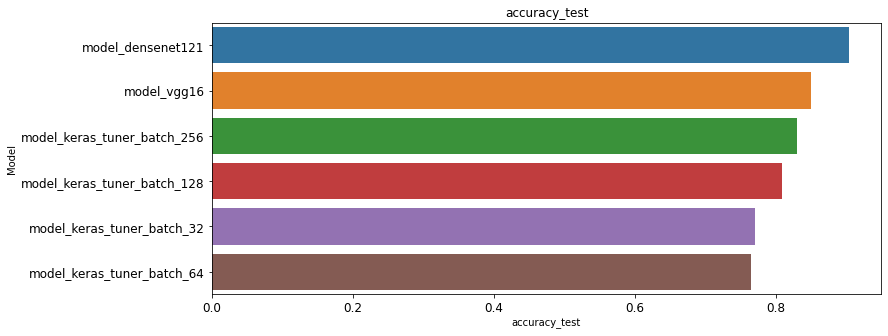

In [91]:
results_plot("accuracy_test", model_results_df)

The plot above demonstrates that the Dense121 model has the best performance.

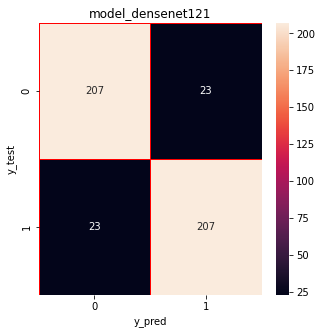

In [93]:
# Observe confusion matrix of DenseNet121 model

plot_cm(model_name_list[-1], cm_list[-1])

Based on this confusion matrix, the model appears to have relatively good performance as the majority of both positive and negative samples are correctly classified (TP + TN = 207 + 207 = 414).

However, there is room for improvement as 23 positive samples were incorrectly classified as negative (FN) and 23 negative samples were incorrectly classified as positive (FP).

### Predict on testing images

In [146]:
# Function to predict 9 random images from testing samples
def show_predictions(model, test_set):
    it = iter(test_set)
    batch = next(it)

    fig, axes = plt.subplots(3, 3, figsize = (10, 10))

    fig.tight_layout()
    fig.subplots_adjust(hspace = .25)

    for i in range(3):
        for j in range(3):
            ax = axes[i, j]
            image = batch[0][i * 3 + j]
            net_input = image.reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1], 3))
            truth = int(batch[1][i * 3 + j])
            ax.axis("off")
            prediction = model.predict(verbose = 0, x = net_input)
            prediction = 1 if prediction > 0.5 else 0
            ax.set_title("Label: %s\nPrediction: %s" % (class_names[truth], class_names[prediction]))
            ax.imshow(image)

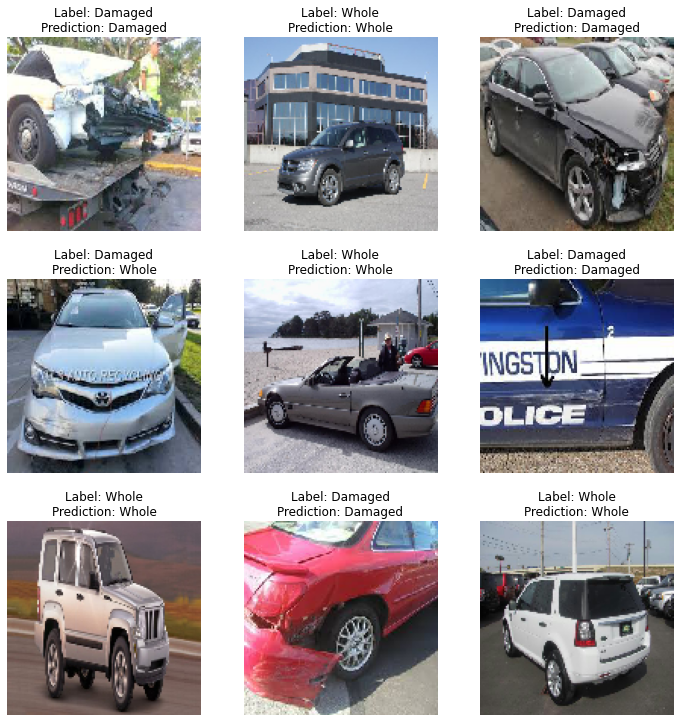

In [148]:
show_predictions(model_densenet121, test_set)

## Conclusion

In this project we tried to create CNN model with hyperparameters tuning to classify damaged car.

Due to a lack of data, we applied data augmentation techniques and added regularization to CNN model.
Then we used Transfer Learning Models(DenseNet121 and VGG16) to get better results.

The results of our project showed that both the VGG16 and DenseNet models performed well in detecting car damage, with an overall test accuracy of over 85%. However, the DenseNet model performed slightly better, achieving a higher accuracy and precision score. This suggests that the DenseNet model is better at identifying damaged cars.

There are some limitations of our project, such as the small size of the dataset. However, the results of our project demonstrate the potential of using deep learning for car damage detection and provide a starting point for future work.

Our project provides a promising solution for automating the process of detecting car damage, which can have significant implications for the insurance and automotive industries.